In [83]:
#import packages
import numpy as np
import csv
from sklearn.utils import resample

from imageio import imread
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
import scipy.linalg as scl
from sklearn.model_selection import KFold
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [18]:
"""
This is an "uglified" version of the FrankeFunction, to minimize use of costly functions like divisions and powers.
It takes as input parameters a meshgrid of coordinates in the x and y direction.
"""
def FrankeFunction(x,y): #still got one division in here
    term1 = 0.75*np.exp(-(0.25*(9*x-2)*(9*x-2)) - 0.25*((9*y-2)*(9*y-2)))
    term2 = 0.75*np.exp(-((9*x+1)*(9*x+1))/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)*(9*x-7)*0.25 - 0.25*((9*y-3)*(9*y-3)))
    term4 = -0.2*np.exp(-(9*x-4)*(9*x-4) - (9*y-7)*(9*y-7))
    return term1 + term2 + term3 + term4

In [169]:
"""
This function creates the Model Matrix, usually dubbed X, for regression analysis.
It takes as input parameters a meshgrid of coordinates in the x and y direction, 
and the polynomial degree P that you wish to fit.

The order of columns is different from the one scikit learn creates, so take care to use the same model-creator when
comparing scikit and this code.

The ordering this function creates is: x^0y^0, x^1y^0, x^2y^0, x^0y^1, x^1y^1, x^0y^2 for a 2nd order polynomial.
"""
def Model(x,y,P): 
#     m = len(x)*len(y) # number of equations
    m=len(x)
    t = sum(range(P+2)) # number of terms in polynomial
    X = np.zeros((m,t)) # Model matrix
#     a = np.matrix.flatten(x)
#     b = np.matrix.flatten(y)
    a=x
    b=x
    c = 0 #counter
    for i in range(P+1):
        for j in range(P+1-i):
            X[:,c] = a**j*b**i
            c +=1
    return X

In [97]:
def runningskl(N_in): #input is number of points in y and x directions
    N = int(N_in*0.8)
    #Create random variables/predictors
    N_v = int(N_in*0.2) #validation set
    
    # create points
    x = np.sort(np.random.uniform(0,1,N))
    y = np.sort(np.random.uniform(0,1,N))
    x = np.random.uniform(0,1,N**2)
    y = np.random.uniform(0,1,N**2)
    x, y = np.meshgrid(x,y,sparse=False)
   
    #create validation set to test bias/variance of kfold
    x_v = np.sort(np.random.uniform(0,1,N_v))
    y_v = np.sort(np.random.uniform(0,1,N_v))
    x_v, y_v = np.meshgrid(x_v,y_v,sparse=False)    
    
    #create datapoints/results
    z = FrankeFunction(x, y)
    z_v = FrankeFunction(x_v,y_v)
    
    # Create noise
    noise_weight = 0.01 #might wanna make a function for this to loop over weights?

    Noise = noise_weight*np.random.randn(N,N)
    Noise_v = noise_weight*np.random.randn(N_v,N_v)
    #add noise
    z_noise = z+Noise
    z_v_noise = z_v + Noise_v
    
    #flatten for use in functions
    z_n = np.matrix.flatten(z_noise) ##### RAVEL?
    z_v_n = np.matrix.flatten(z_v_noise)
    z_test=z_v_n[:,np.newaxis]

    #number of folds for crossvalidation
    k=10

    #polydegrees to run
    degrees=np.arange(1,15)
    
    err=[]
    bi=[]
    vari=[]
    
    z_pred = np.empty((len(z_v_n), k),dtype=np.float64)

    kFold=KFold(n_splits=k,shuffle=True)
    for deg in degrees:        
        X = Model(x,y,deg)
        X_v = Model(x_v,y_v,deg)

        j=0

        for train_index,test_index in kFold.split(X):
            xtrain = X[train_index]
            xtest = X[test_index]
            ztrain=z_n[train_index]
            ztest=z_n[test_index]
            lin = LinearRegression(fit_intercept=False)

            z_pred[:,j] = lin.fit(xtrain,ztrain).predict(X_v).ravel()

            j+=1
        error = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
        bias = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
        variance = np.mean( np.var(z_pred, axis=1, keepdims=True) )
        err.append(error)
        bi.append(bias)
        vari.append(variance)
    max_pd = 12 #max polynomial degree to plot to
    plt.figure()
    plt.plot(degrees[:max_pd],err[:max_pd],'k',label='MSE')
    plt.plot(degrees[:max_pd],bi[:max_pd],'b',label='Bias^2')
    plt.plot(degrees[:max_pd],vari[:max_pd],'y',label='Var')
    summ=np.zeros(len(vari))
    for i in range(len(vari)):
        summ[i]=vari[i]+bi[i]
    plt.plot(degrees[:max_pd],summ[:max_pd],'ro',label='sum')
    plt.show()

Number of datapoints: 100


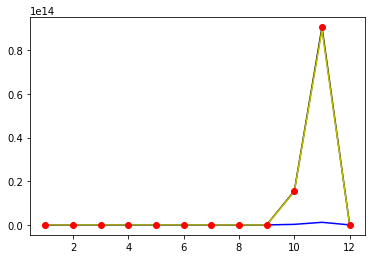

Number of datapoints: 121


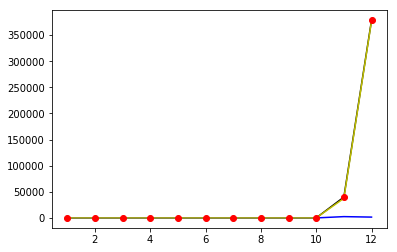

Number of datapoints: 144


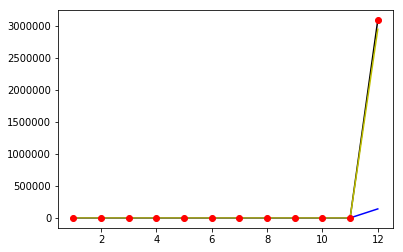

Number of datapoints: 169


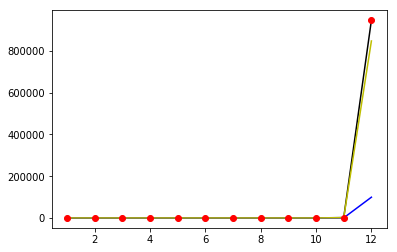

Number of datapoints: 196


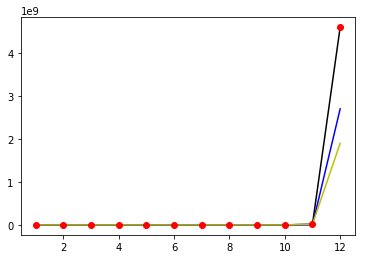

Number of datapoints: 225


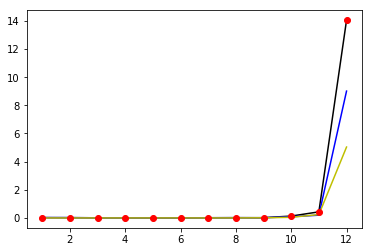

Number of datapoints: 256


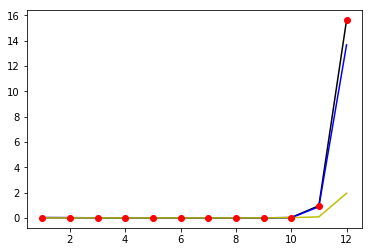

Number of datapoints: 289


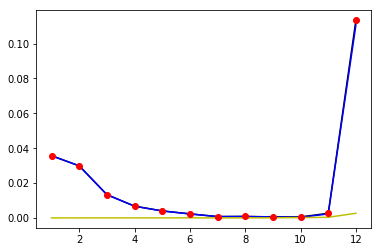

Number of datapoints: 324


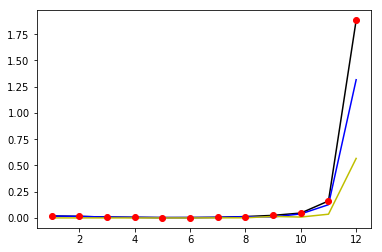

Number of datapoints: 361


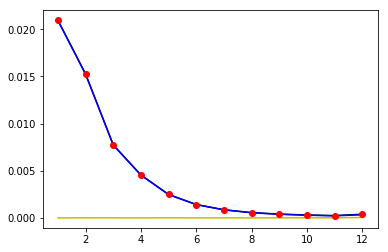

Number of datapoints: 400


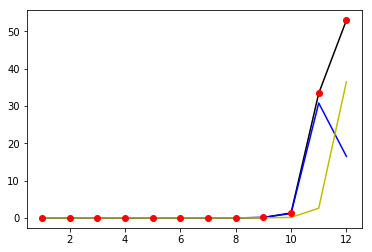

Number of datapoints: 441


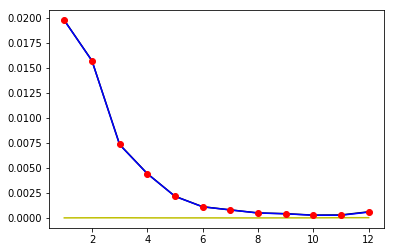

Number of datapoints: 484


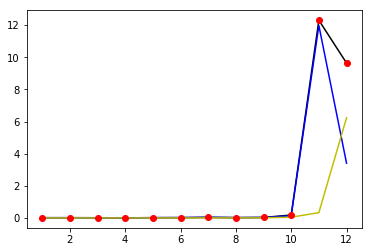

Number of datapoints: 529


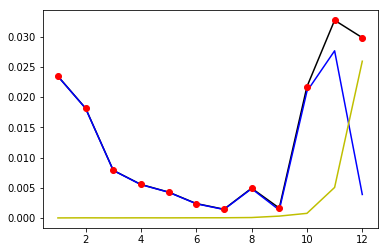

Number of datapoints: 576


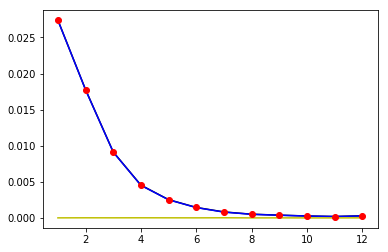

Number of datapoints: 625


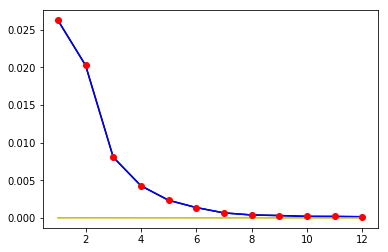

Number of datapoints: 676


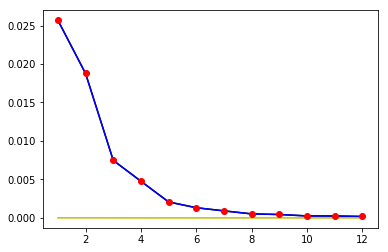

Number of datapoints: 729


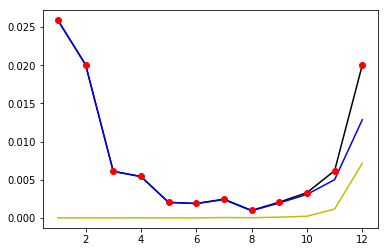

Number of datapoints: 784


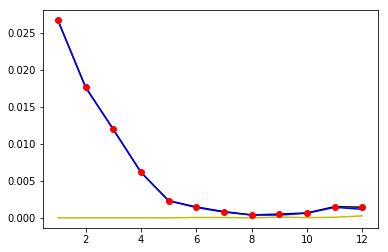

Number of datapoints: 841


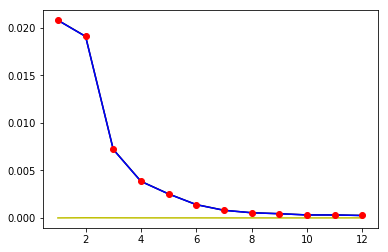

Number of datapoints: 900


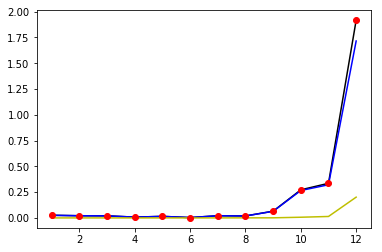

Number of datapoints: 961


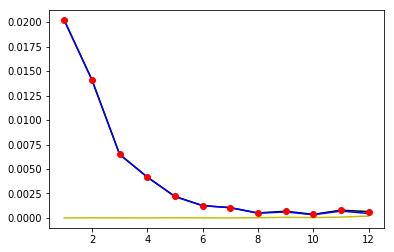

Number of datapoints: 1024


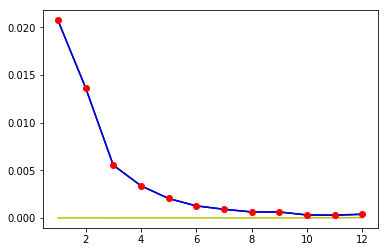

Number of datapoints: 1089


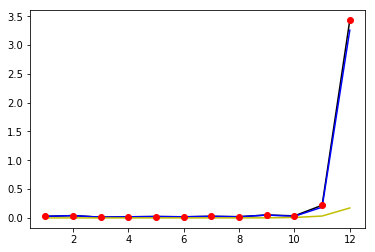

Number of datapoints: 1156


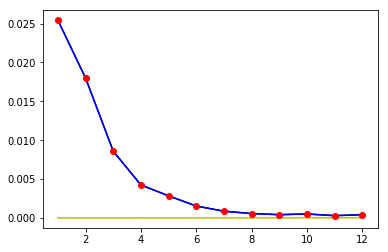

Number of datapoints: 1225


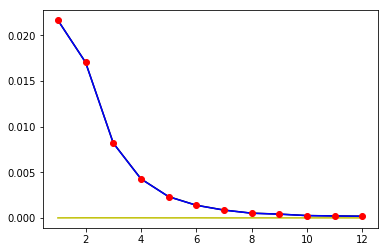

Number of datapoints: 1296


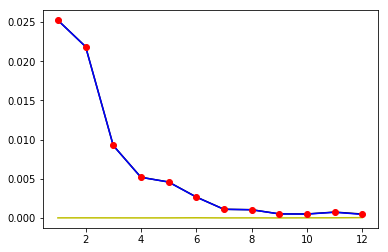

Number of datapoints: 1369


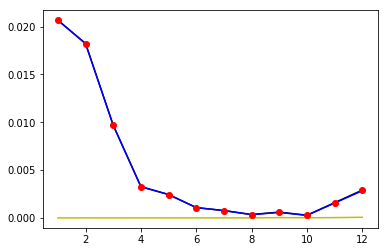

Number of datapoints: 1444


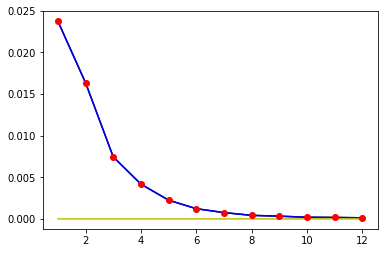

Number of datapoints: 1521


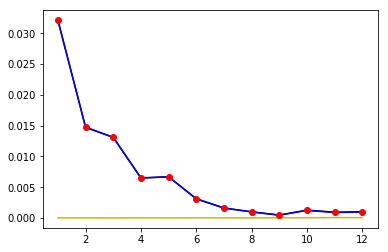

In [98]:
for N in range(10,40):
    print("Number of datapoints: {}".format(N*N))
    runningskl(N)

# BV BOOTS

In [232]:
def runningboos(N_in): #input is number of points in y and x directions
#     N=int(N_in*0.8)
    N=N_in
    #Create random variables/predictors
#     N_v = int(N_in*0.2) #validation set
    N_v=20
    
    # create points
#     x = np.sort(np.random.uniform(0,1,N))
#     y = np.sort(np.random.uniform(0,1,N))
    np.random.seed(123)
    x = np.random.uniform(0,1,N**2)
    np.random.seed(123)
    y = np.random.uniform(0,1,N**2)
#     x, y = np.meshgrid(x,y,sparse=False)
   
    #create validation set to test bias/variance of kfold
#     x_v = np.sort(np.random.uniform(0,1,N_v))
#     y_v = np.sort(np.random.uniform(0,1,N_v))
    np.random.seed(123)
    x_v = np.random.uniform(0,1,N_v**2)
    np.random.seed(123)
    y_v = np.random.uniform(0,1,N_v**2)
#     x_v, y_v = np.meshgrid(x_v,y_v,sparse=False)    
    
    #create datapoints/results
    z = FrankeFunction(x, y)
    z_v = FrankeFunction(x_v,y_v)
    # Create noise
    noise_weight = 0.01 #might wanna make a function for this to loop over weights?

#     Noise = noise_weight*np.random.randn(N,N)
    np.random.seed(123)
    Noise=noise_weight*np.random.randn(N**2)
#     Noise_v = noise_weight*np.random.randn(N_v,N_v)
    np.random.seed(123)
    Noise_v=noise_weight*np.random.randn(N_v**2)
    #add noise
    z_noise = z+Noise
    z_v_noise = z_v + Noise_v
    
    #flatten for use in functions
    z_n = np.matrix.flatten(z_noise) ##### RAVEL?
    z_v_n = np.matrix.flatten(z_v_noise)
    z_test=z_v_n[:,np.newaxis]

    #polydegrees to run
    degrees=np.arange(1,15)
    
    n_bootstraps = 100
    
    
    err=[]
    bi=[]
    vari=[]
#     deg_thing = []
    lin = LinearRegression(fit_intercept=False)
    for deg in degrees:
        X = Model(x,y,deg)
        X_v = Model(x_v,y_v,deg)
        z_pred = np.empty((len(z_v_n), n_bootstraps),dtype=np.float64)

        for i in range(n_bootstraps):
                x_, y_ = resample(X, z_n)
                # Evaluate the new model on the same test data each time.
                z_pred[:, i] = lin.fit(x_, y_).predict(X_v).ravel()
        
        error = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
        if deg == 8:
            deg_thing=error
        bias = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
        variance = np.mean( np.var(z_pred, axis=1, keepdims=True) )
        err.append(error)
        bi.append(bias)
        vari.append(variance)

    max_pd = 200 #max polynomial degree to plot to
    plt.figure()
    plt.plot(degrees[:max_pd],err[:max_pd],'k',label='MSE')
    plt.plot(degrees[:max_pd],bi[:max_pd],'b',label='Bias^2')
    plt.plot(degrees[:max_pd],vari[:max_pd],'y',label='Var')
    summ=np.zeros(len(vari))
    for i in range(len(err)):
        summ[i]=vari[i]+bi[i]
    plt.plot(degrees[:max_pd],summ[:max_pd],'ro',label='sum')

    plt.xlabel('Polynomial degree')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()
#     print(deg_thing)
    return deg_thing

Number of datapoints: 5


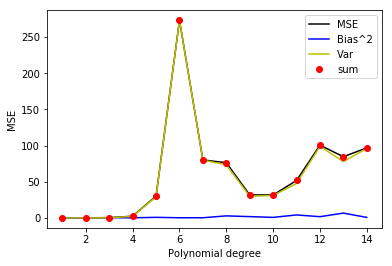

Number of datapoints: 10


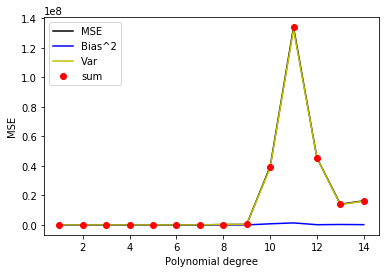

Number of datapoints: 16


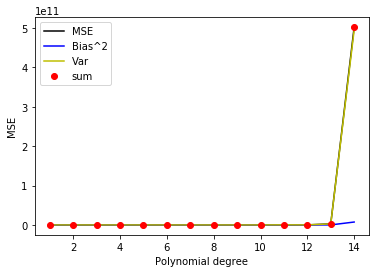

Number of datapoints: 23


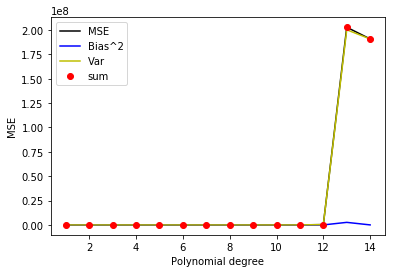

Number of datapoints: 31


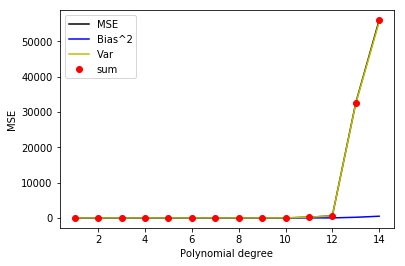

Number of datapoints: 40


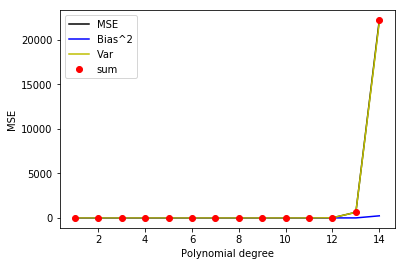

Number of datapoints: 51


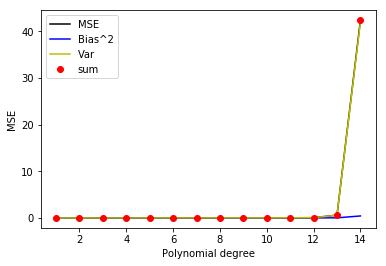

Number of datapoints: 64


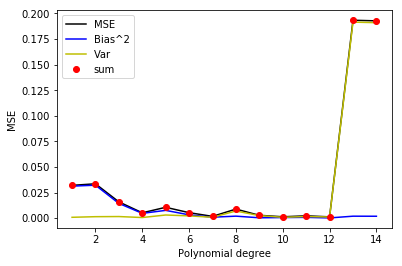

Number of datapoints: 77


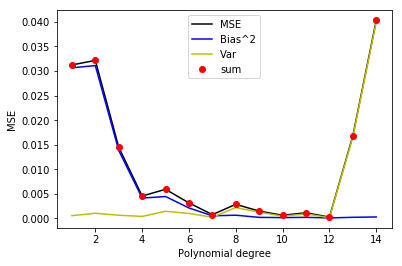

Number of datapoints: 92


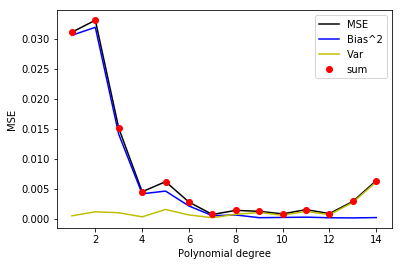

Number of datapoints: 108


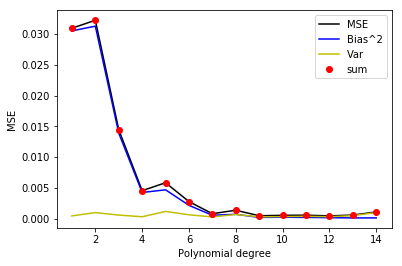

Number of datapoints: 125


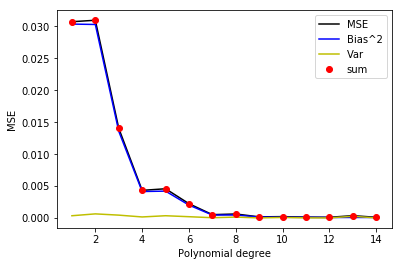

Number of datapoints: 144


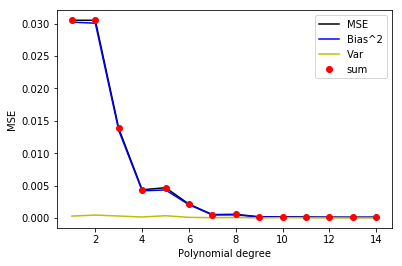

Number of datapoints: 163


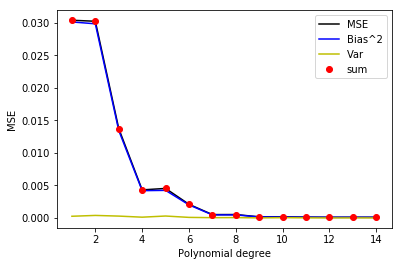

Number of datapoints: 184


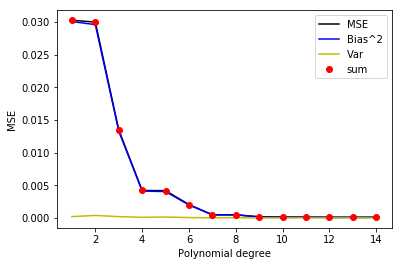

Number of datapoints: 207


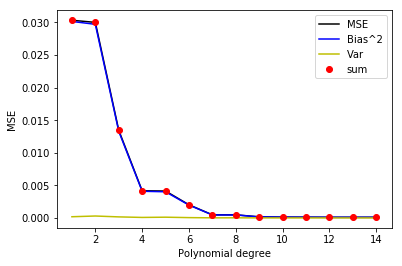

Number of datapoints: 231


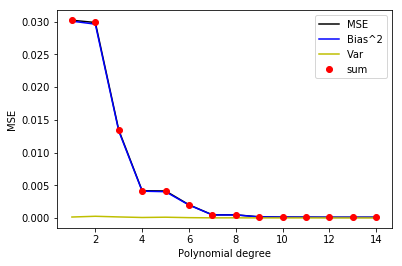

In [233]:
degger=[]

for N in range(3,20):
    print("Number of datapoints: {}".format(int((N*0.8)*(N*0.8))))
    ape = runningboos(N)
#     print(ape)
    degger.append(ape)

In [236]:
# plt.figure()
# # plt.semilogy(degger[:])
# ai=np.arange(3,20)
# bi=ai**2
# plt.plot(bi[3:],degger[3:])
# plt.show()
# # print(degger)